In [1]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Load VGG-16 model pretrained on ImageNet dataset
model = vgg16.VGG16(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




Prediction (top 3): [('n07747607', 'orange', 0.9942146), ('n07749582', 'lemon', 0.00417321), ('n03991062', 'pot', 0.0003257421)]


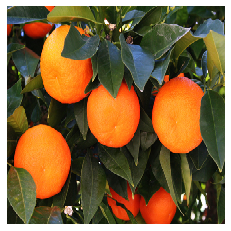

In [3]:
img_path = 'orange.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Prediction (top 3):', vgg16.decode_predictions(preds, top=3)[0])

In [4]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

In [5]:
# Get current session (assuming tf backend)
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x
# Added noise
x_noise = np.zeros_like(x)

0 0.9914425 [('n07747607', 'orange', 0.9914425), ('n07749582', 'lemon', 0.0057591684), ('n03991062', 'pot', 0.0005261899)]
20 0.26842234 [('n07747607', 'orange', 0.26842234), ('n07749582', 'lemon', 0.06301449), ('n07718472', 'cucumber', 0.05611436)]
40 0.045737762 [('n07717410', 'acorn_squash', 0.06906318), ('n07718472', 'cucumber', 0.06046947), ('n07716906', 'spaghetti_squash', 0.057800226)]
60 0.021684937 [('n07717410', 'acorn_squash', 0.06781104), ('n07716906', 'spaghetti_squash', 0.06150731), ('n07718472', 'cucumber', 0.05389742)]
80 0.016194921 [('n07717410', 'acorn_squash', 0.060733534), ('n07716906', 'spaghetti_squash', 0.058310393), ('n07718472', 'cucumber', 0.05334283)]


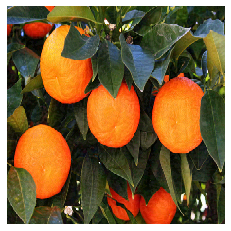

Prediction (after fgsm): [('n07716906', 'spaghetti_squash', 0.054518506), ('n07717410', 'acorn_squash', 0.05334945), ('n07718472', 'cucumber', 0.0503535)]


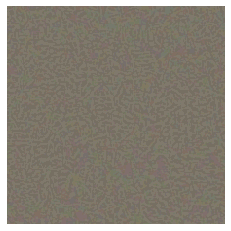

In [6]:
# Set variables
epochs = 100
epsilon = 0.05
prev_probs = []

for i in range(epochs): 
    # One hot encode the initial class
    target = K.one_hot(initial_class, 1000)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = K.categorical_crossentropy(target, model.output)
    grads = K.gradients(loss, model.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][initial_class])

    if i%20==0:
        #print out the iteration, probability for initially predicted class, and current top3
        print(i, preds[0][initial_class], vgg16.decode_predictions(preds, top=3)[0])

plot_img(x_adv)
print('Prediction (after fgsm):', vgg16.decode_predictions(preds, top=3)[0])
plot_img(x_adv-x)

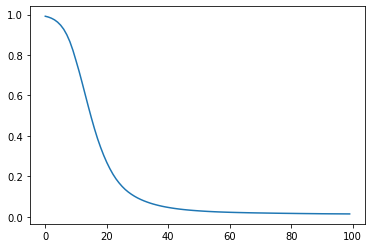

In [7]:
# Plot the probability of the target class w.r.t epochs
plt.plot(np.arange(0,len(prev_probs)), prev_probs)
plt.show()